In [ ]:
# Basic data preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('all_english_data_merged.csv')


print("Current label distribution in your dataset:")
label_counts = df['label'].value_counts()
print(label_counts)


print(f"\nNumber of unique labels: {df['label'].nunique()}")
print(f"Unique labels: {df['label'].unique()}")


print("\nFirst few rows:")
print(df[['text', 'label']].head(10))

print("\nLast few rows:")
print(df[['text', 'label']].tail(10))

Current label distribution in your dataset:
label
normal       31284
offensive    24950
hate         23605
Name: count, dtype: int64

Number of unique labels: 3
Unique labels: ['hate' 'normal' 'offensive']

First few rows:
                                                text   label
0                                dalits are lowlives    hate
1             gay people are a burden to our society    hate
2                              Arabs are not welcome    hate
3  I'm not saying we should actually eliminate he...    hate
4                       bananas are for black people    hate
5                          asian people are the shit  normal
6  women can not reproduce kids but men can in al...    hate
7                i hate wearing black in the summer!  normal
8               Who cares what Chinese people think?    hate
9         i try to punch a letter box when i see one    hate

Last few rows:
                                                    text      label
79829  just because th

In [ ]:

print("Checking label distribution pattern...")


total_rows = len(df)
part_size = total_rows // 5

for i in range(5):
    start_idx = i * part_size
    end_idx = start_idx + part_size if i < 4 else total_rows
    part_df = df.iloc[start_idx:end_idx]
    print(f"\nPart {i+1} (rows {start_idx}-{end_idx}):")
    print(part_df['label'].value_counts())

# Now let's shuffle the entire dataset properly
print("\nShuffling the dataset...")
df_shuffled = shuffle(df, random_state=42).reset_index(drop=True)

# Verify the shuffle worked
print("\nLabel distribution after shuffling (first 100 rows):")
print(df_shuffled.head(100)['label'].value_counts())

print("\nLabel distribution after shuffling (last 100 rows):")
print(df_shuffled.tail(100)['label'].value_counts())

Checking label distribution pattern...

Part 1 (rows 0-15967):
label
hate      8244
normal    7723
Name: count, dtype: int64

Part 2 (rows 15967-31934):
label
hate      8258
normal    7709
Name: count, dtype: int64

Part 3 (rows 31934-47901):
label
hate         6249
offensive    5027
normal       4691
Name: count, dtype: int64

Part 4 (rows 47901-63868):
label
offensive    12491
normal        2719
hate           757
Name: count, dtype: int64

Part 5 (rows 63868-79839):
label
normal       8442
offensive    7432
hate           97
Name: count, dtype: int64

Shuffling the dataset...

Label distribution after shuffling (first 100 rows):
label
normal       38
offensive    34
hate         28
Name: count, dtype: int64

Label distribution after shuffling (last 100 rows):
label
normal       48
hate         28
offensive    24
Name: count, dtype: int64


In [ ]:
# Map labels to numerical values
unique_labels = sorted(df_shuffled['label'].unique())
print(f"Unique labels in dataset: {unique_labels}")

# label mapping
label_map = {label: idx for idx, label in enumerate(unique_labels)}
reverse_label_map = {idx: label for label, idx in label_map.items()}

print(f"Label mapping: {label_map}")

df_shuffled['label_encoded'] = df_shuffled['label'].map(label_map)

#final distribution
print("\nFinal label distribution:")
print(df_shuffled['label'].value_counts())
print(f"\nEncoded label distribution:")
print(df_shuffled['label_encoded'].value_counts())

# remove any NaN values
df_shuffled = df_shuffled.dropna(subset=['label_encoded', 'clean_text'])
print(f"\nFinal dataset size: {len(df_shuffled)}")

Unique labels in dataset: ['hate', 'normal', 'offensive']
Label mapping: {'hate': 0, 'normal': 1, 'offensive': 2}

Final label distribution:
label
normal       31284
offensive    24950
hate         23605
Name: count, dtype: int64

Encoded label distribution:
label_encoded
1    31284
2    24950
0    23605
Name: count, dtype: int64

Final dataset size: 79839


In [ ]:
# Splitting of data
train_df, temp_df = train_test_split(
    df_shuffled,
    test_size=0.3,
    random_state=42,
    stratify=df_shuffled['label_encoded']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label_encoded']
)

print(f"\nDataset splits:")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

print("\nTrain label distribution:")
print(train_df['label'].value_counts())
print("\nValidation label distribution:")
print(val_df['label'].value_counts())
print("\nTest label distribution:")
print(test_df['label'].value_counts())


Dataset splits:
Train: 55887
Validation: 11976
Test: 11976

Train label distribution:
label
normal       21899
offensive    17465
hate         16523
Name: count, dtype: int64

Validation label distribution:
label
normal       4692
offensive    3743
hate         3541
Name: count, dtype: int64

Test label distribution:
label
normal       4693
offensive    3742
hate         3541
Name: count, dtype: int64


In [ ]:
# Model setup
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Dataset class for 3 classes
class MultiClassDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = MultiClassDataset(
    train_df['clean_text'].values,
    train_df['label_encoded'].values,
    tokenizer
)

val_dataset = MultiClassDataset(
    val_df['clean_text'].values,
    val_df['label_encoded'].values,
    tokenizer
)

test_dataset = MultiClassDataset(
    test_df['clean_text'].values,
    test_df['label_encoded'].values,
    tokenizer
)

# Compute metrics for multiple classes
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Weighted metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None, labels=list(range(len(unique_labels)))
    )

    metrics = {
        'accuracy': acc,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall,
    }

    # Add per-class metrics
    for i, label_name in reverse_label_map.items():
        metrics[f'f1_{label_name}'] = f1_per_class[i]
        metrics[f'precision_{label_name}'] = precision_per_class[i]
        metrics[f'recall_{label_name}'] = recall_per_class[i]

    return metrics


num_classes = len(unique_labels)
print(f"Training model with {num_classes} classes: {unique_labels}")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=reverse_label_map,
    label2id=label_map
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training model with 3 classes: ['hate', 'normal', 'offensive']


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(f"Transformers version: {transformers.__version__}")

# Version-specific training arguments
if int(transformers.__version__.split('.')[0]) >= 4:
    # For Transformers v4.x and above
    training_args = TrainingArguments(
        output_dir='./multi_class_results',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./multi_class_logs',
        logging_steps=200,
        eval_strategy='steps',
        eval_steps=200,
        save_strategy='steps',
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model='f1_weighted',
        greater_is_better=True,
        learning_rate=2e-5,
        fp16=True,
        dataloader_pin_memory=False,
        report_to=None,
    )
else:
    # For Transformers v3.x and below
    training_args = TrainingArguments(
        output_dir='./multi_class_results',
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./multi_class_logs',
        logging_steps=200,
        evaluation_strategy='steps',
        eval_steps=200,
        save_steps=200,
        load_best_model_at_end=True,
        metric_for_best_model='f1_weighted',
        greater_is_better=True,
        learning_rate=2e-5,
        fp16=True,
        dataloader_pin_memory=False,
    )

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]  # Increased patience
)

# Train the model
print(f"Starting training for {num_classes}-class model...")
print(f"Classes: {unique_labels}")
trainer.train()

# Save the model
model_save_path = f"multi_class_hate_speech_detector_{num_classes}_classes"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")

Transformers version: 4.57.1
Starting training for 3-class model...
Classes: ['hate', 'normal', 'offensive']


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ritiknst2425 (ritiknst2425-ru) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Hate,Precision Hate,Recall Hate,F1 Normal,Precision Normal,Recall Normal,F1 Offensive,Precision Offensive,Recall Offensive
200,1.027000,0.843140,0.622328,0.612996,0.637058,0.622328,0.456927,0.626785,0.359503,0.620939,0.538510,0.733163,0.750685,0.770312,0.732033
400,0.791600,0.708760,0.697562,0.695827,0.699282,0.697562,0.649668,0.613186,0.690765,0.645250,0.701728,0.597187,0.802895,0.777666,0.829816
600,0.692600,0.668935,0.718270,0.717076,0.718740,0.718270,0.632717,0.675866,0.594747,0.711156,0.678406,0.747229,0.804304,0.809859,0.798824
800,0.642200,0.636843,0.738978,0.738442,0.739564,0.738978,0.665780,0.698172,0.636261,0.722889,0.696934,0.750853,0.826677,0.832160,0.821266
1000,0.622000,0.606144,0.737892,0.736514,0.746850,0.737892,0.702710,0.636906,0.783677,0.687159,0.775308,0.617008,0.830362,0.815187,0.846113
1200,0.600800,0.626715,0.722862,0.720139,0.759061,0.722862,0.696594,0.579906,0.872070,0.645637,0.820572,0.532182,0.835805,0.851441,0.820732
1400,0.606200,0.579318,0.752088,0.752977,0.758372,0.752088,0.709644,0.657356,0.770969,0.720674,0.762120,0.683504,0.834466,0.849239,0.820198
1600,0.582200,0.558591,0.763110,0.763035,0.763023,0.763110,0.704858,0.700922,0.708839,0.744656,0.750704,0.738704,0.841112,0.837215,0.845044
1800,0.582800,0.551902,0.757599,0.755820,0.764462,0.757599,0.676341,0.765988,0.605479,0.752187,0.691318,0.824808,0.835564,0.854708,0.817259
2000,0.563700,0.536740,0.771209,0.771489,0.771824,0.771209,0.722066,0.717834,0.726348,0.754705,0.753024,0.756394,0.839283,0.846467,0.832220


Model saved to: multi_class_hate_speech_detector_3_classes



=== 3-CLASS MODEL TEST RESULTS ===
eval_loss: 0.5045
eval_accuracy: 0.7902
eval_f1_weighted: 0.7898
eval_precision_weighted: 0.7895
eval_recall_weighted: 0.7902
eval_f1_hate: 0.7530
eval_precision_hate: 0.7606
eval_recall_hate: 0.7456
eval_f1_normal: 0.7724
eval_precision_normal: 0.7784
eval_recall_normal: 0.7665
eval_f1_offensive: 0.8463
eval_precision_offensive: 0.8308
eval_recall_offensive: 0.8624
eval_runtime: 34.5913
eval_samples_per_second: 346.2140
eval_steps_per_second: 21.6530
epoch: 1.4887

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        hate       0.76      0.75      0.75      3541
      normal       0.78      0.77      0.77      4693
   offensive       0.83      0.86      0.85      3742

    accuracy                           0.79     11976
   macro avg       0.79      0.79      0.79     11976
weighted avg       0.79      0.79      0.79     11976


=== OVERALL METRICS ===
Accuracy: 0.7902
Precision (weighted): 0.7895
Re

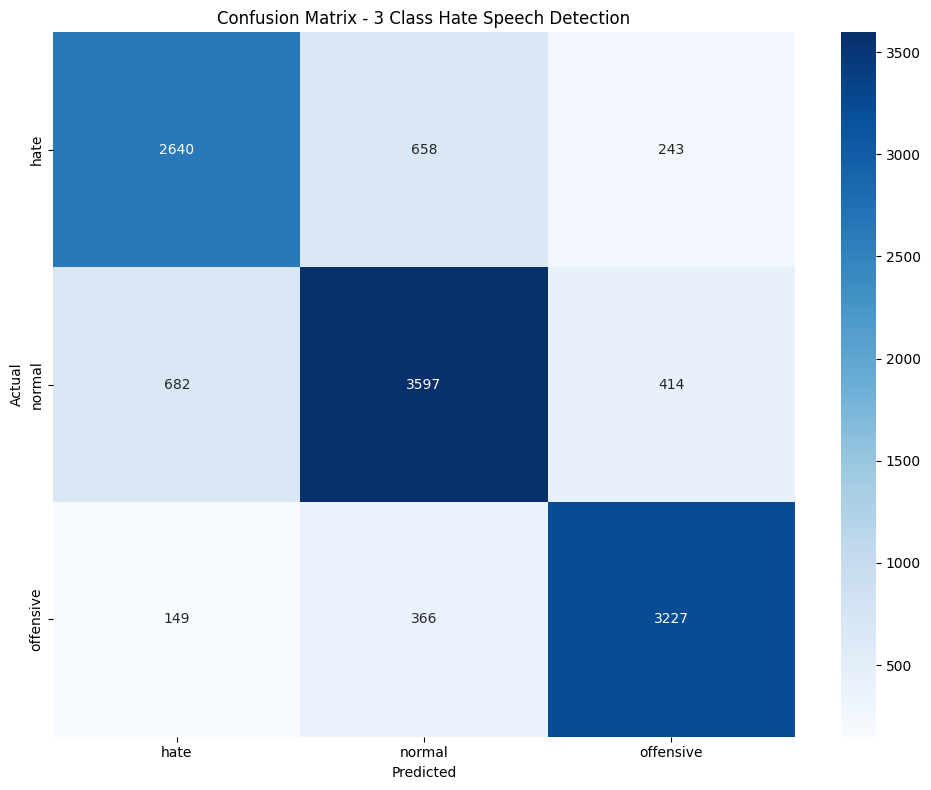


Class Mapping:
  0: hate
  1: normal
  2: offensive


In [ ]:
# Evaluate the model
test_results = trainer.evaluate(test_dataset)
print(f"\n=== {num_classes}-CLASS MODEL TEST RESULTS ===")
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")

# Detailed predictions
test_predictions = trainer.predict(test_dataset)
y_pred = np.argmax(test_predictions.predictions, axis=1)
y_true = test_predictions.label_ids

# Classification report
print(f"\n=== DETAILED CLASSIFICATION REPORT ===")
target_names = [reverse_label_map[i] for i in sorted(reverse_label_map.keys())]
print(classification_report(y_true, y_pred, target_names=target_names))

# Calculate overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n=== OVERALL METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {num_classes} Class Hate Speech Detection')
plt.tight_layout()
plt.show()

# Print class names for reference
print(f"\nClass Mapping:")
for idx, name in enumerate(target_names):
    print(f"  {idx}: {name}")

In [ ]:

# Simple direct download
import os
import shutil
from google.colab import files

def simple_download_model(model_path="multi_class_hate_speech_detector_3_classes"):
    """
    Simple direct download of the model
    """
    if not os.path.exists(model_path):
        print(f"Model path '{model_path}' does not exist!")
        return

    # Create a zip of the model directly
    zip_name = "hate_speech_model_complete"
    shutil.make_archive(zip_name, 'zip', model_path)

    # Create a simple usage file separately
    usage_code = '''# Save this as hate_speech_detector.py
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class HateSpeechDetector:
    def __init__(self, model_path="./model"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
        self.id2label = self.model.config.id2label
        print(f"Loaded model with classes: {list(self.id2label.values())}")

    def predict(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

        result = {
            'prediction': self.id2label[pred_idx],
            'confidence': probs[0][pred_idx].item(),
            'probabilities': {}
        }

        for idx, prob in enumerate(probs[0]):
            result['probabilities'][self.id2label[idx]] = prob.item()

        return result

# Usage:
# detector = HateSpeechDetector()
# result = detector.predict("your text")
'''

    with open("usage_example.py", "w") as f:
        f.write(usage_code)


    with open("requirements.txt", "w") as f:
        f.write("torch\ntransformers\nnumpy")


    files.download(f"{zip_name}.zip")
    files.download("usage_example.py")
    files.download("requirements.txt")

    print("Downloaded: model.zip, usage_example.py, requirements.txt")


simple_download_model()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: model.zip, usage_example.py, requirements.txt


In [ ]:
# Test with examples
test_texts = [
    "I love everyone",
    "I hate all immigrants",
    "You're an idiot"
]

for text in test_texts:
    result = detector.predict(text)
    print(f"Text: {text}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']}")
    print(f"Probabilities: {result['probabilities']}")
    print()

print("✓ All tests passed! Model is working correctly.")

ValueError: You have to specify either input_ids or inputs_embeds